# Image analysis for control charts for Power Bed Laser Fusion

## Data manipolation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,127875690.0,38.119,-54.480,8.96,224,800.0,805.0,1580.9,0,271,0.00000,0.0
1,127875700.0,38.118,-54.489,8.96,224,807.0,801.0,1596.0,0,271,0.00721,10.0
2,127875710.0,38.119,-54.498,8.96,224,813.0,809.0,1593.2,0,271,0.01442,20.0
3,127875720.0,38.119,-54.508,8.96,224,813.0,824.0,1573.0,0,271,0.02163,30.0
4,127875730.0,38.121,-54.515,8.96,224,820.0,825.0,1581.0,0,271,0.02884,40.0


Generate a temperature matrix

In [2]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [27]:
digits_round = 1
x_range = (26.292, 38.089)
y_range = (-66.633, -54.62)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df,layer_ids, x_range, y_range, digits_round)

C:\Users\Utente\AppData\Local\Temp\ipykernel_13092\437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_13092\437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


In [28]:
list_25l.shape

(25, 120, 118)

In [31]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming list_25l is a numpy array of shape (25, 120, 118)

num_layers = list_25l.shape[0]
height = list_25l.shape[1]
width = list_25l.shape[2]
smallest_cluster_pixels = []

for i in range(num_layers):
    # Extract the current layer
    current_layer = list_25l[i, :, :]

    # Standardize the data before reshaping for PCA
    scaler_pca = StandardScaler()
    current_layer_scaled = scaler_pca.fit_transform(current_layer)

    # Reshape the standardized data for PCA
    X = current_layer_scaled.reshape(-1, 1)

    # Apply PCA
    pca = PCA(n_components=1)
    scores = pca.fit_transform(X)

    # Compute Hotelling’s T² statistic for each pixel
    explained_variance = pca.explained_variance_
    if explained_variance[0] > 1e-8:
        T2 = (scores ** 2) / explained_variance[0]
    else:
        T2 = np.zeros_like(scores)

    # Standardize T2 values before K-means (optional but potentially useful)
    scaler_kmeans = StandardScaler()
    T2_scaled = scaler_kmeans.fit_transform(T2.reshape(-1, 1))

    # Apply K-means clustering on the T² map
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
    clusters_flat = kmeans.fit_predict(T2_scaled)
    clusters_map = clusters_flat.reshape(height, width)

    # Calculate the size of each cluster
    unique_clusters, counts = np.unique(clusters_map, return_counts=True)
    cluster_sizes = dict(zip(unique_clusters, counts))

    # Find the label of the smallest cluster
    smallest_cluster_label = min(cluster_sizes, key=cluster_sizes.get)

    # Extract the pixel coordinates belonging to the smallest cluster
    smallest_cluster_indices = np.where(clusters_map == smallest_cluster_label)
    smallest_cluster_coords = list(zip(smallest_cluster_indices[0], smallest_cluster_indices[1]))

    # Extract the pixel values from the original *standardized* layer for the smallest cluster
    smallest_cluster_values = current_layer_scaled[smallest_cluster_indices]

    smallest_cluster_pixels.append({
        "layer": i + 1,
        "cluster_label": smallest_cluster_label,
        "pixel_coordinates": smallest_cluster_coords,
        "pixel_values": smallest_cluster_values
    })

# Print the extracted pixels for each layer
for layer_data in smallest_cluster_pixels:
    print(f"Layer: {layer_data['layer']}")
    print(f"  Smallest Cluster Label: {layer_data['cluster_label']}")
    print(f"  Number of Pixels in Smallest Cluster: {len(layer_data['pixel_coordinates'])}")
    print(f"  Pixel Coordinates (row, col): {layer_data['pixel_coordinates'][:5]} ...")
    print(f"  Pixel Values (Standardized): {layer_data['pixel_values'][:5]} ...\n")

Layer: 1
  Smallest Cluster Label: 1
  Number of Pixels in Smallest Cluster: 1214
  Pixel Coordinates (row, col): [(0, 0), (0, 1), (0, 2), (0, 4), (0, 5)] ...
  Pixel Values (Standardized): [3.21319468 2.51914955 2.42611981 2.65830058 1.83175947] ...

Layer: 2
  Smallest Cluster Label: 0
  Number of Pixels in Smallest Cluster: 2275
  Pixel Coordinates (row, col): [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)] ...
  Pixel Values (Standardized): [-2.07838391 -3.54873379 -3.67182242 -1.59394541 -2.24159386] ...

Layer: 3
  Smallest Cluster Label: 1
  Number of Pixels in Smallest Cluster: 2563
  Pixel Coordinates (row, col): [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6)] ...
  Pixel Values (Standardized): [1.90949726 1.65305608 1.61524688 2.46551369 2.34177797] ...

Layer: 4
  Smallest Cluster Label: 0
  Number of Pixels in Smallest Cluster: 2190
  Pixel Coordinates (row, col): [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)] ...
  Pixel Values (Standardized): [2.73211413 3.03067569 2.42820053 2.07329263 1.99

In [34]:
# Create a list to store the data
data = []

# Iterate through each layer's smallest cluster data
for layer_data in smallest_cluster_pixels:
    layer_id = layer_data['layer']
    pixel_coordinates = layer_data['pixel_coordinates']
    pixel_values = layer_data['pixel_values']
    
    # Add each pixel's data to the list
    for (y, x), temp_std in zip(pixel_coordinates, pixel_values):
        data.append({'x': x, 'y': y, 'temp_std': temp_std, 'layer_id': layer_id})

# Create a DataFrame from the list
high_T2_cluster = pd.DataFrame(data)
high_T2_cluster.head()

,x,y,temp_std,layer_id
0,0,0,3.213195,1
1,1,0,2.519150,1
2,2,0,2.426120,1
3,4,0,2.658301,1
4,5,0,1.831759,1


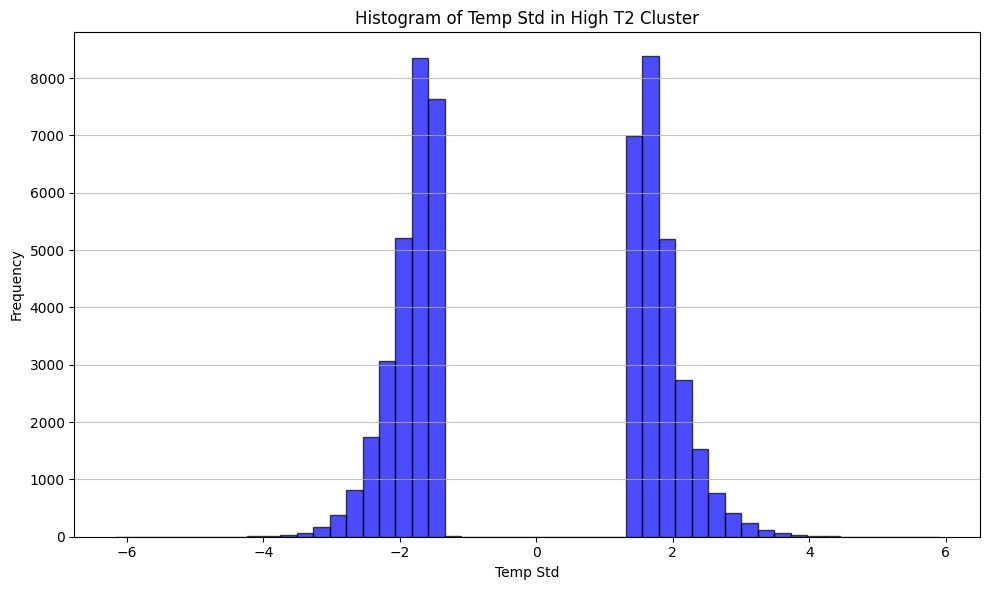

In [39]:
import matplotlib.pyplot as plt

# Create a histogram of 'temp_std'
plt.figure(figsize=(10, 6))
plt.hist(high_T2_cluster['temp_std'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Temp Std')
plt.ylabel('Frequency')
plt.title('Histogram of Temp Std in High T2 Cluster')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

The temperature in the high T2 cluster is bimodal, signaling cold and hot spots. Separate the data at temp_std = 0.

In [40]:
# Separate into cold_spots and hot_spots based on temp_std threshold
cold_spots = high_T2_cluster[high_T2_cluster['temp_std'] < 0].copy()
hot_spots = high_T2_cluster[high_T2_cluster['temp_std'] >= 0].copy()

# Reset indices for both DataFrames
cold_spots.reset_index(drop=True, inplace=True)
hot_spots.reset_index(drop=True, inplace=True)

# Display the first few rows of each DataFrame
cold_spots.head(), hot_spots.head()

(    x  y  temp_std  layer_id  cluster
 0  51  0 -2.116901         1        1
 1  88  0 -2.392175         1        1
 2  56  2 -1.742388         1        1
 3  62  2 -1.775139         1        1
 4  68  3 -2.090448         1        1,
    x  y  temp_std  layer_id  cluster
 0  0  0  3.213195         1        0
 1  1  0  2.519150         1        0
 2  2  0  2.426120         1        0
 3  4  0  2.658301         1        0
 4  5  0  1.831759         1        0)

### Cold spots

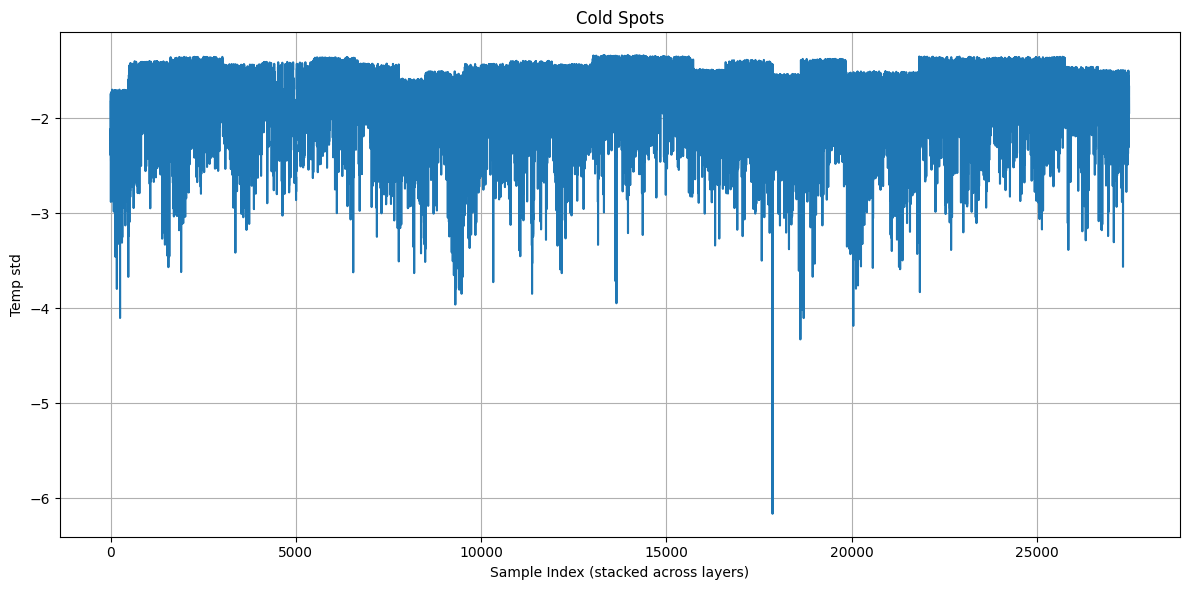

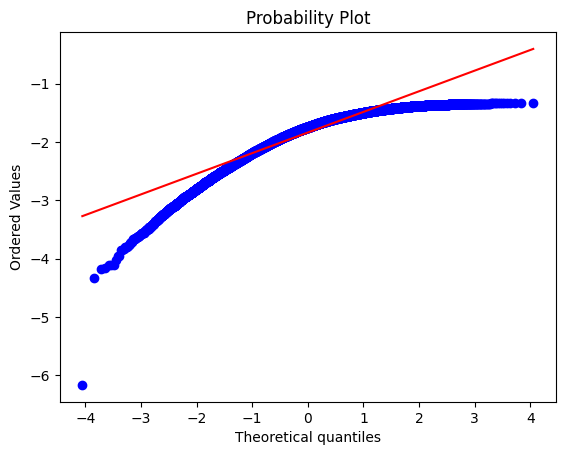

c:\Users\Utente\anaconda3\envs\qda_environment\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.896
Shapiro-wilk test p-value = 0.000
Runs test statistic = -36.667
Runs test p-value = 0.000



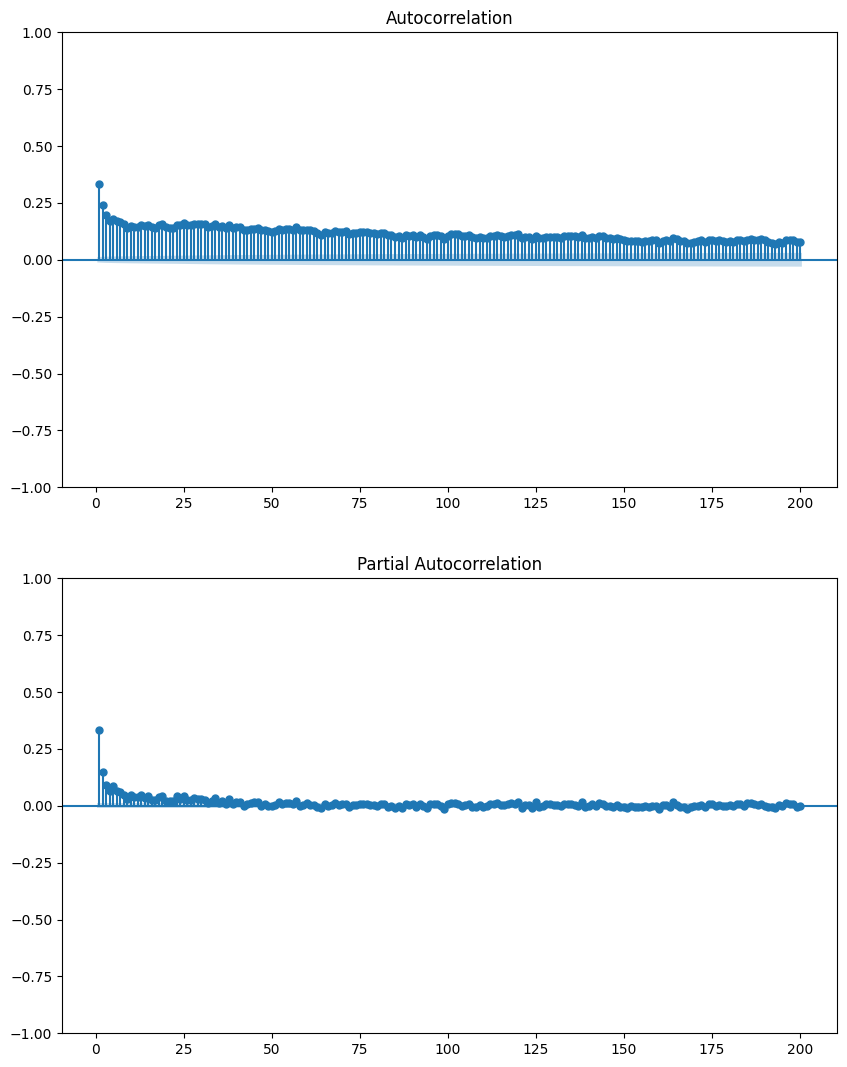

In [41]:
import matplotlib.pyplot as plt

# Step 5: Plot
plt.figure(figsize=(12, 6))
plt.plot(cold_spots['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Cold Spots')
plt.grid(True)
plt.tight_layout()
plt.show()

import qdatoolkit as qda

_ = qda.Assumptions(cold_spots['temp_std']).normality()  # Controllo di normalità
_ = qda.Assumptions(cold_spots['temp_std']).independence()  # Controllo di indipendenza

### Hot spots

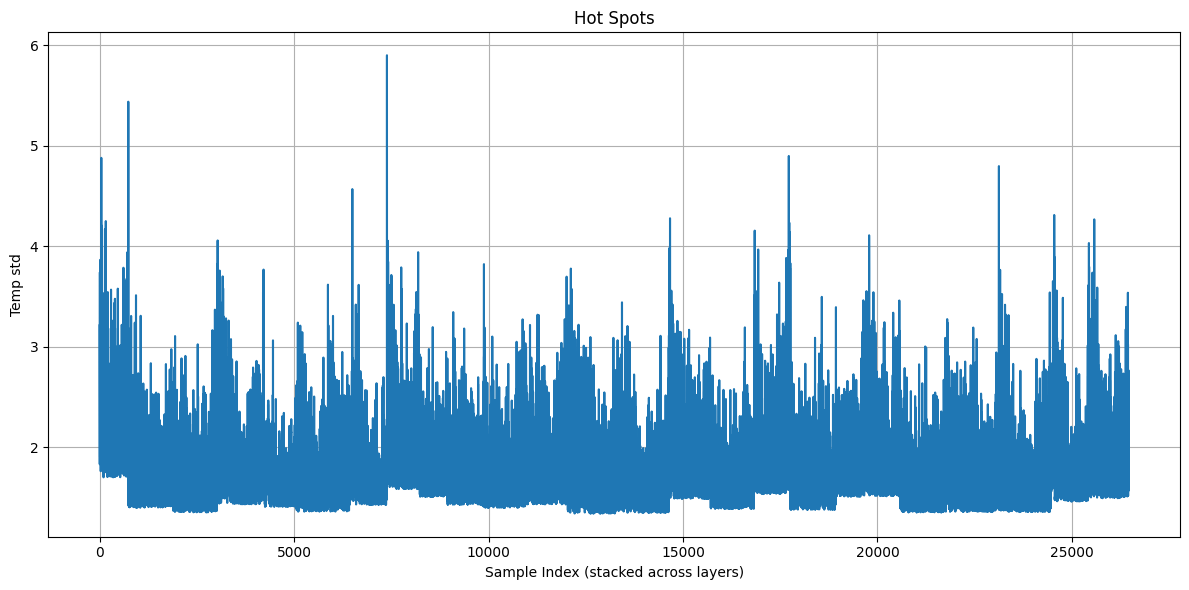

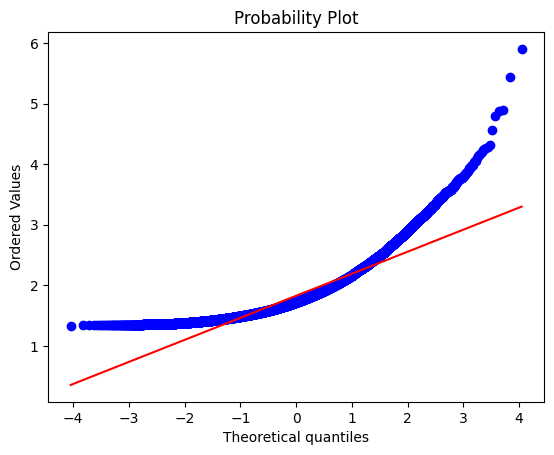

Shapiro-wilk test statistic = 0.861
Shapiro-wilk test p-value = 0.000
Runs test statistic = -35.805
Runs test p-value = 0.000



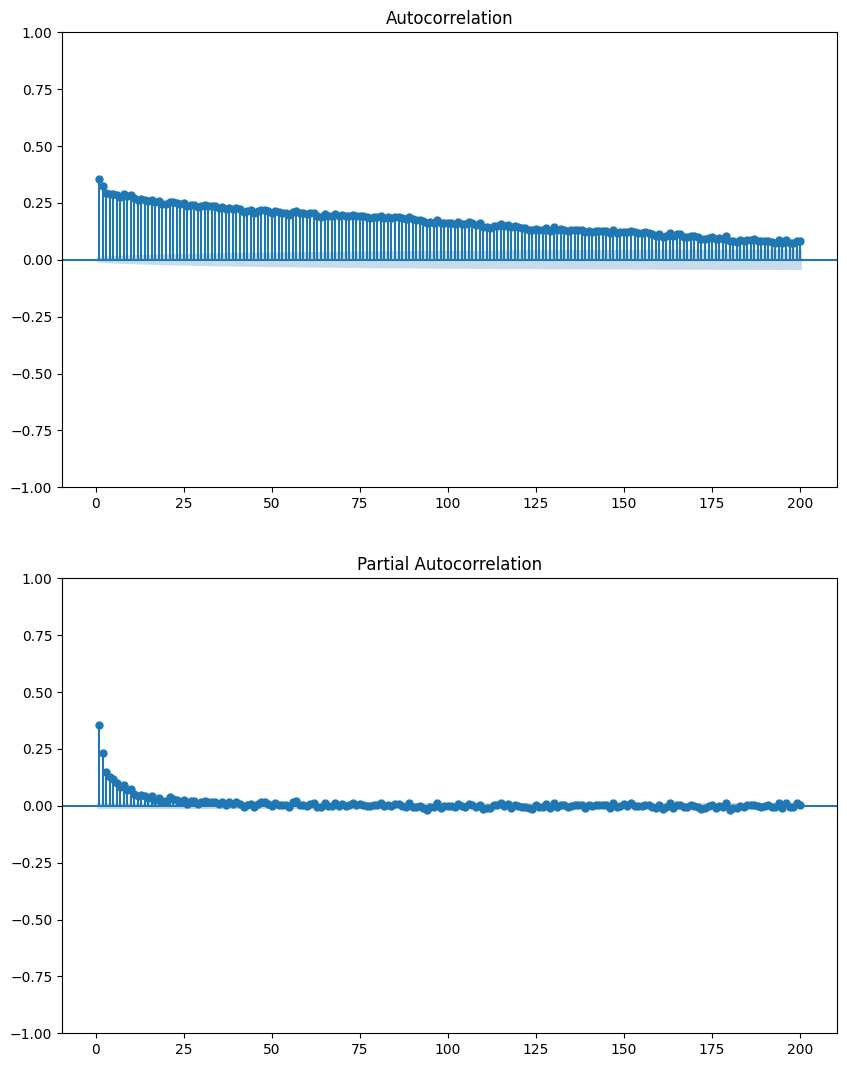

In [43]:
import matplotlib.pyplot as plt

# Step 5: Plot
plt.figure(figsize=(12, 6))
plt.plot(hot_spots['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Hot Spots')
plt.grid(True)
plt.tight_layout()
plt.show()

import qdatoolkit as qda

_ = qda.Assumptions(hot_spots['temp_std']).normality()  # Controllo di normalità
_ = qda.Assumptions(hot_spots['temp_std']).independence()  # Controllo di indipendenza

Coefficiente: -7.155249107905702e-07
Intercetta: 1.8382809343840478


c:\Users\Utente\anaconda3\envs\qda_environment\lib\site-packages\qdatoolkit\models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


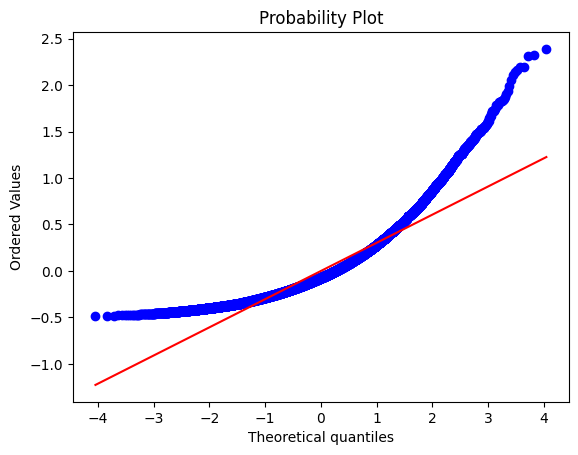

c:\Users\Utente\anaconda3\envs\qda_environment\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.885
Shapiro-wilk test p-value = 0.000
Runs test statistic = -86.375
Runs test p-value = 0.000



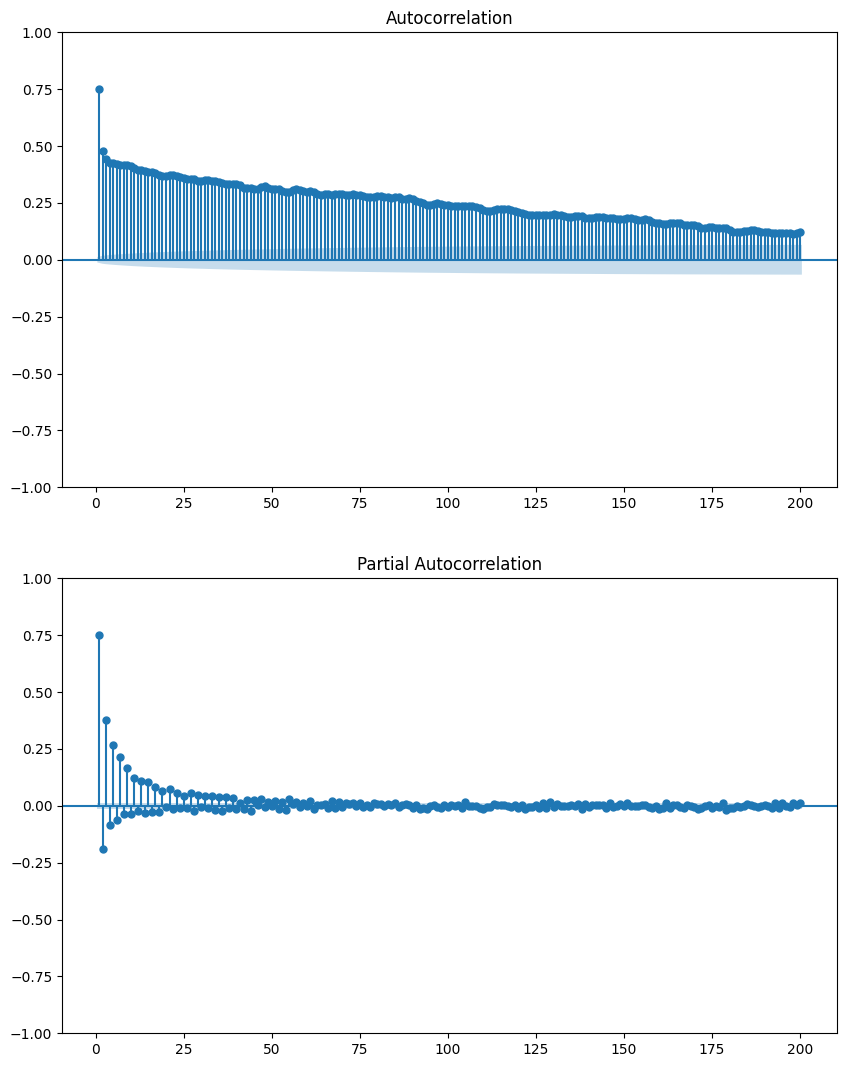

In [47]:
from sklearn.linear_model import LinearRegression

# Calcola la differenza prima (diff1) della serie temporale dei valori in cluster2
diff1 = hot_spots['temp_std'].diff(1).dropna().reset_index(drop=True)
diff1.head()

# Prepare the feature matrix (index and diff1) and the response variable (temp_std)
X_pixel = pd.DataFrame({'index': range(len(diff1)), 'diff': diff1})
y_diff1 = hot_spots['temp_std'].iloc[1:].values  # Align with diff1 by skipping the first two values

# Convert to numpy arrays for model fitting
X_pixel = X_pixel.values
y_diff1 = y_diff1

# Crea e allena il modello lineare
model = LinearRegression()
model.fit(X_pixel, y_diff1)

# Visualizza i coefficienti
print("Coefficiente:", model.coef_[0])
print("Intercetta:", model.intercept_)

# Calcola i residui del modello
residuals = y_diff1 - model.predict(X_pixel)
_=qda.Assumptions(residuals).normality()
_=qda.Assumptions(residuals).independence()


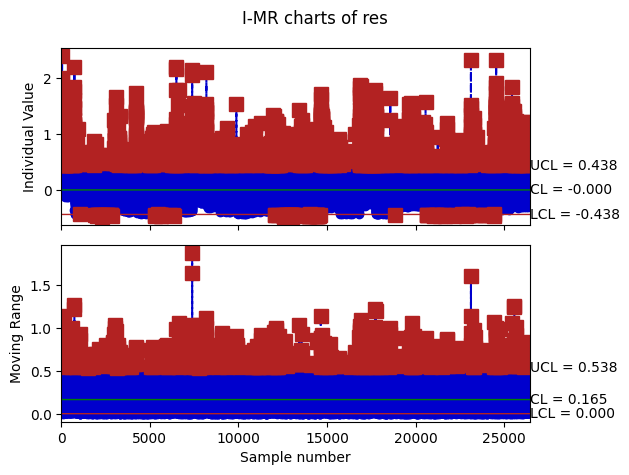

In [48]:
# Put the residuals in a dataframe
df_SCC = pd.DataFrame(residuals, columns=['res'])

# Plot the IMR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'res')